### Sample notebook for multiple linear regression (MLR) for Abalone data 
アワビデータの線形重回帰分析の手順例  

Data: https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/  
Abalone Data (modified: some data are replaced by N/A):

Sex / nominal / -- / M, F, and I (infant)  
Length / continuous / mm / Longest shell measurement  
Diameter / continuous / mm / perpendicular to length  
Height / continuous / mm / with meat in shell  
Whole weight / continuous / grams / whole abalone  
Shucked weight / continuous / grams / weight of meat  
Viscera weight / continuous / grams / gut weight (after bleeding)  
Shell weight / continuous / grams / after being dried  
Rings / integer / -- / +1.5 gives the age in years  

#### Import libraries  

In [33]:
import sys
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf

#### Import my libraries

In [34]:
my_libs_dir = '../'
if not my_libs_dir in sys.path:
    sys.path.append(my_libs_dir)  # add the path to my_lib directory 

# The following lines are needed to auto-reload my library file
# Without these lines, my library file is read only once and
# modifications of my library file are not reflected.
%load_ext autoreload
%autoreload 1
%aimport my_libs.linear_reg
# import from my library file
from my_libs.linear_reg import step_aic_forward, calc_vifs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Parameters

In [35]:
%config InlineBackend.figure_formats = {'png', 'retina'} #high-reso images
font = {'family' : 'Yu Mincho'}
matplotlib.rc('font', **font)

# To show all rows and columns in the results 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

#### Step 1. Collect possible explanatory variables  
目的変数に影響を与えていそうな要因は、可能な限り網羅的に説明変数に取り入れる。  

##### Check & read CSV file, replace column labels if needed, etc.  
encoding='shift-jis' may be needed.    
CSVファイルをチェックしてから読み込む。必要に応じて列ラベルを変更。  
CSVファイルの漢字コードがShift-JISの場合は encoding='shift-jis' が必要。　　

In [36]:
csv_in = 'abalone_modified.csv'
df_all = pd.read_csv(csv_in, delimiter=',', skiprows=0, header=None)
# no header in csv, so set columns explicitly
df_all.columns = ['sex', 'len', 'd', 'h', 'w_all', 'w_meat', 'w_gut', 'w_shell', 'ring']
print(df_all.shape)
print(df_all.info())
display(df_all.head())

(4177, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
sex        4177 non-null object
len        4177 non-null float64
d          4176 non-null float64
h          4177 non-null float64
w_all      4175 non-null float64
w_meat     4177 non-null float64
w_gut      4177 non-null float64
w_shell    4177 non-null float64
ring       4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None


,sex,len,d,h,w_all,w_meat,w_gut,w_shell,ring
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,NaN,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


##### Check numerical / category variables if needed  
数値列・カテゴリー列の様子をみる  

In [37]:
display(df_all.describe())
display(df_all.describe(exclude='number'))

,len,d,h,w_all,w_meat,w_gut,w_shell,ring
count,4177.000000,4176.000000,4177.000000,4175.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407892,0.139516,0.828871,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099250,0.041827,0.490450,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441750,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153500,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


,sex
count,4177
unique,3
top,M
freq,1528


##### See rows including missing data  
欠損値を含む行を表示してみる  

In [38]:
display(df_all[df_all.isnull().any(axis=1)])

,sex,len,d,h,w_all,w_meat,w_gut,w_shell,ring
3,M,0.440,NaN,0.125,0.516,0.2155,0.1140,0.155,10
5,I,0.425,0.300,0.095,NaN,0.1410,0.0775,0.120,8
7,F,0.545,0.425,0.125,NaN,0.2940,0.1495,0.260,16


##### Delete rows including missing data, or fill missing data  
欠損値を含む行を削除する (または欠損値を埋める)  

In [39]:
df_all = df_all.dropna().reset_index(drop=True)
#df_all = df_all.fillna(df_all.mean()) # if you want to fill missing data instead of deleting them
print(df_all.shape)
display(df_all.head())

(4174, 9)


,sex,len,d,h,w_all,w_meat,w_gut,w_shell,ring
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20


##### Separate explanatory variables and objective variable  
説明変数と目的変数を分ける  

In [40]:
X_all_org = df_all.loc[:, 'sex':'w_shell']  # explanatory variables
y = df_all['ring']  # objective variable
print('X_all_org:', X_all_org.shape)
display(X_all_org.head())
print('y:', y.shape)
print(y.head())

X_all_org: (4174, 8)


,sex,len,d,h,w_all,w_meat,w_gut,w_shell
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055
4,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330


y: (4174,)
0    15
1     7
2     9
3     7
4    20
Name: ring, dtype: int64


##### Apply get_dummies()  
ダミー変数化  

In [41]:
X_all = pd.get_dummies(X_all_org, drop_first=True)
print('X_all:', X_all.shape)
display(X_all.head())

X_all: (4174, 9)


,len,d,h,w_all,w_meat,w_gut,w_shell,sex_I,sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0,0
3,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,1,0
4,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,0,0


#### Step 2. Scatter plot and correlation coefficients between all combination of explanatory variables  
変数間の総当たり散布図を描画。相関係数も算出しておく  

##### all by all Pearson correlation coefficients;  
総当たりのPearson相関係数  

In [42]:
corr_all = X_all.corr(method='pearson')
display(corr_all)

,len,d,h,w_all,w_meat,w_gut,w_shell,sex_I,sex_M
len,1.000000,0.986824,0.827555,0.925252,0.897911,0.903016,0.897679,-0.551546,0.236762
d,0.986824,1.000000,0.833662,0.925445,0.893159,0.899723,0.905311,-0.564281,0.240469
h,0.827555,0.833662,1.000000,0.819178,0.774907,0.798264,0.817327,-0.518572,0.215422
w_all,0.925252,0.925445,0.819178,1.000000,0.969399,0.966367,0.955353,-0.557675,0.252168
w_meat,0.897911,0.893159,0.774907,0.969399,1.000000,0.931939,0.882607,-0.521938,0.251896
w_gut,0.903016,0.899723,0.798264,0.966367,0.931939,1.000000,0.907653,-0.556193,0.242286
w_shell,0.897679,0.905311,0.817327,0.955353,0.882607,0.907653,1.000000,-0.547004,0.235566
sex_I,-0.551546,-0.564281,-0.518572,-0.557675,-0.521938,-0.556193,-0.547004,1.000000,-0.522557
sex_M,0.236762,0.240469,0.215422,0.252168,0.251896,0.242286,0.235566,-0.522557,1.000000


##### Pickup explanatory variable pairs with large absolute value of correlation coefficient;  
相関係数の絶対値が大きい説明変数ペアの出力   

Method 1. Straight forward method  

In [43]:
th_corr = 0.3
n_X = corr_all.shape[0]
corr_large = []
for i in range(n_X):
    for j in range(i+1, n_X):
        cc1 = corr_all.iat[i,j]
        if cc1 < -th_corr or cc1 > th_corr:
            corr_large.append([corr_all.columns[i], corr_all.columns[j], cc1])
corr_large.sort(reverse=True, key=lambda x: abs(x[2]))
display(corr_large)

[['len', 'd', 0.9868243090115014],
 ['w_all', 'w_meat', 0.9693985446065839],
 ['w_all', 'w_gut', 0.96636748122764],
 ['w_all', 'w_shell', 0.9553531436656604],
 ['w_meat', 'w_gut', 0.9319388550966373],
 ['d', 'w_all', 0.9254445248747081],
 ['len', 'w_all', 0.9252519790478465],
 ['w_gut', 'w_shell', 0.90765288117074],
 ['d', 'w_shell', 0.9053113238944824],
 ['len', 'w_gut', 0.9030160824486531],
 ['d', 'w_gut', 0.8997227868688753],
 ['len', 'w_meat', 0.8979107127746633],
 ['len', 'w_shell', 0.897678509336786],
 ['d', 'w_meat', 0.8931586950571656],
 ['w_meat', 'w_shell', 0.8826068189019752],
 ['d', 'h', 0.8336617140875108],
 ['len', 'h', 0.8275548517614453],
 ['h', 'w_all', 0.8191784349998144],
 ['h', 'w_shell', 0.8173265128288668],
 ['h', 'w_gut', 0.7982642959196766],
 ['h', 'w_meat', 0.7749074469901643],
 ['d', 'sex_I', -0.5642807865477013],
 ['w_all', 'sex_I', -0.557674560391533],
 ['w_gut', 'sex_I', -0.5561927240387842],
 ['len', 'sex_I', -0.5515457053873143],
 ['w_shell', 'sex_I', -0.

Method 2. Rather tricky method ...  

In [44]:
th_corr = 0.3
keep = np.triu(np.ones(corr_all.shape), k=1).astype('bool').flatten()
#print(np.ones(corr_all.shape))  # debug
#print(np.triu(np.ones(corr_all.shape), k=1))  # debug
#print(np.triu(np.ones(corr_all.shape), k=1).astype('bool'))  # debug
#print(keep)  # debug
triu = corr_all.stack()[keep]
#print(corr_all.stack())  # debug
triu_sorted = triu[ np.abs(triu).sort_values(ascending=False).index ]
#print(np.abs(triu).sort_values(ascending=False))  # debug
#print(np.abs(triu).sort_values(ascending=False).index)  # debug
print(triu_sorted[ (triu_sorted < -th_corr) | (triu_sorted > th_corr) ])

len      d          0.986824
w_all    w_meat     0.969399
         w_gut      0.966367
         w_shell    0.955353
w_meat   w_gut      0.931939
d        w_all      0.925445
len      w_all      0.925252
w_gut    w_shell    0.907653
d        w_shell    0.905311
len      w_gut      0.903016
d        w_gut      0.899723
len      w_meat     0.897911
         w_shell    0.897679
d        w_meat     0.893159
w_meat   w_shell    0.882607
d        h          0.833662
len      h          0.827555
h        w_all      0.819178
         w_shell    0.817327
         w_gut      0.798264
         w_meat     0.774907
d        sex_I     -0.564281
w_all    sex_I     -0.557675
w_gut    sex_I     -0.556193
len      sex_I     -0.551546
w_shell  sex_I     -0.547004
sex_I    sex_M     -0.522557
w_meat   sex_I     -0.521938
h        sex_I     -0.518572
dtype: float64


##### all by all scatter plots of explanatory variables;  
変数間の総当たり散布図  

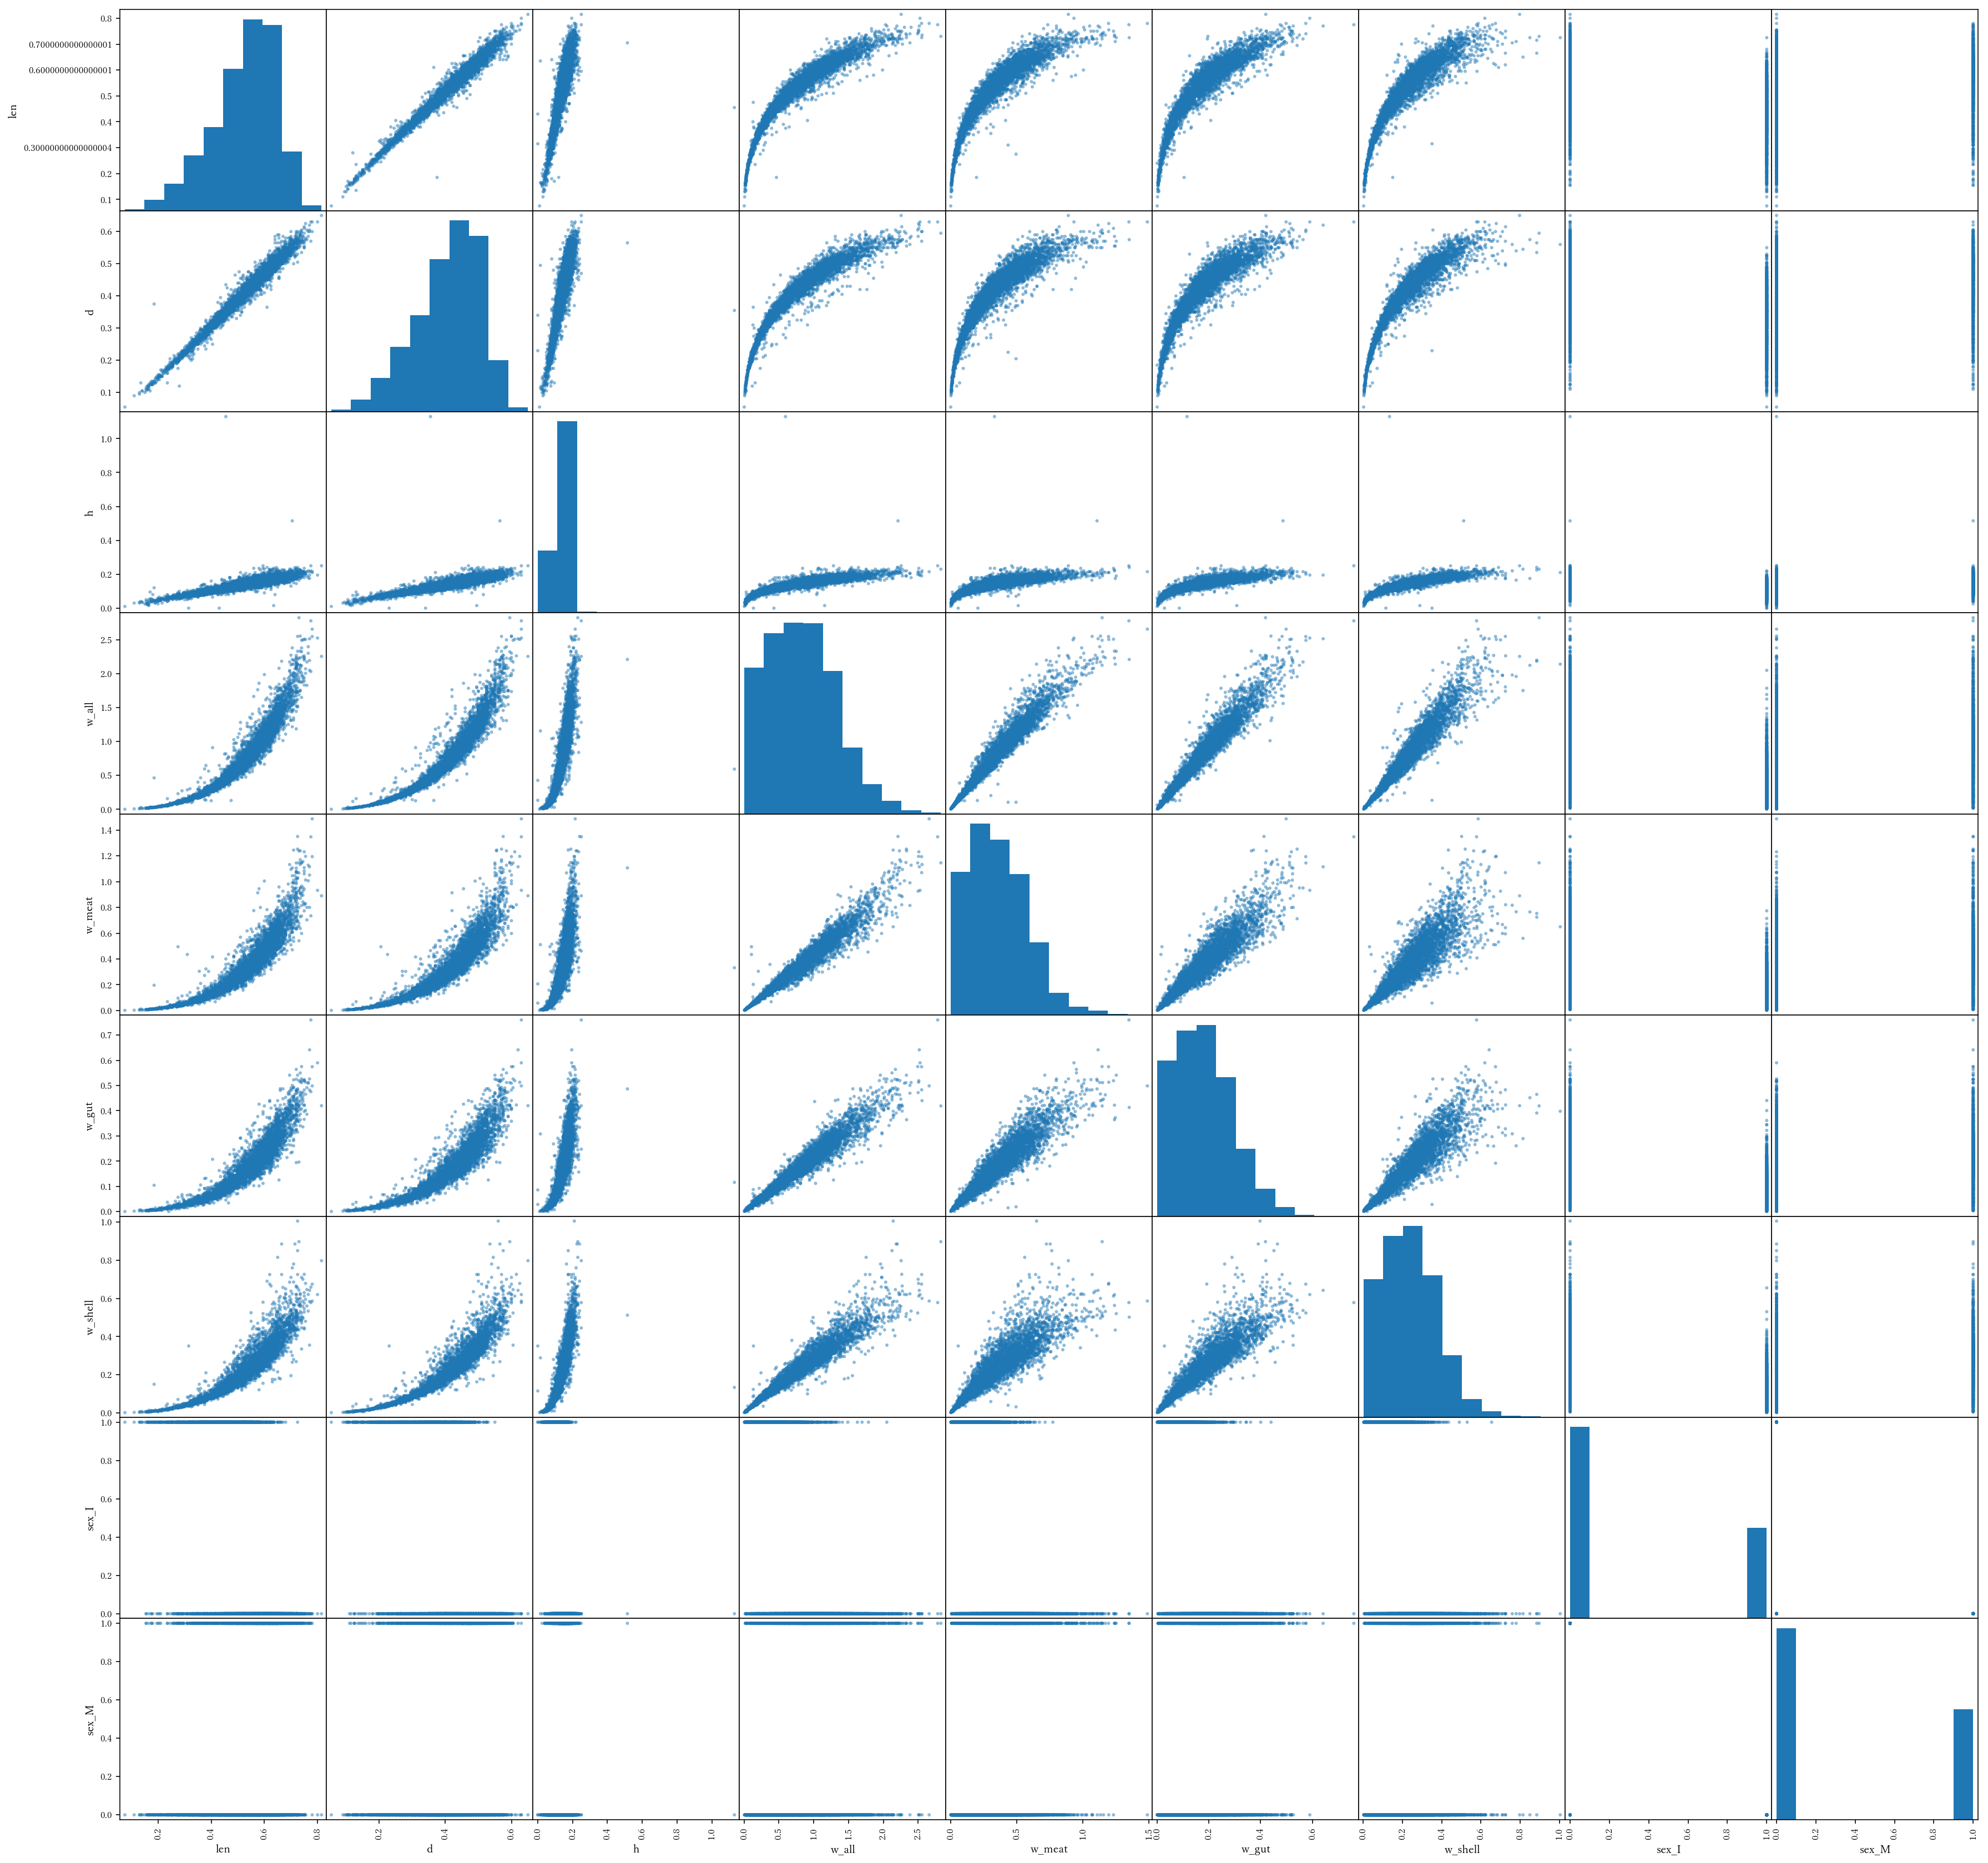

In [45]:
scatter_matrix(X_all, figsize=(30,30))
plt.show()

##### if you want to use seaborn instead of matplotlib
seabornを使うなら  

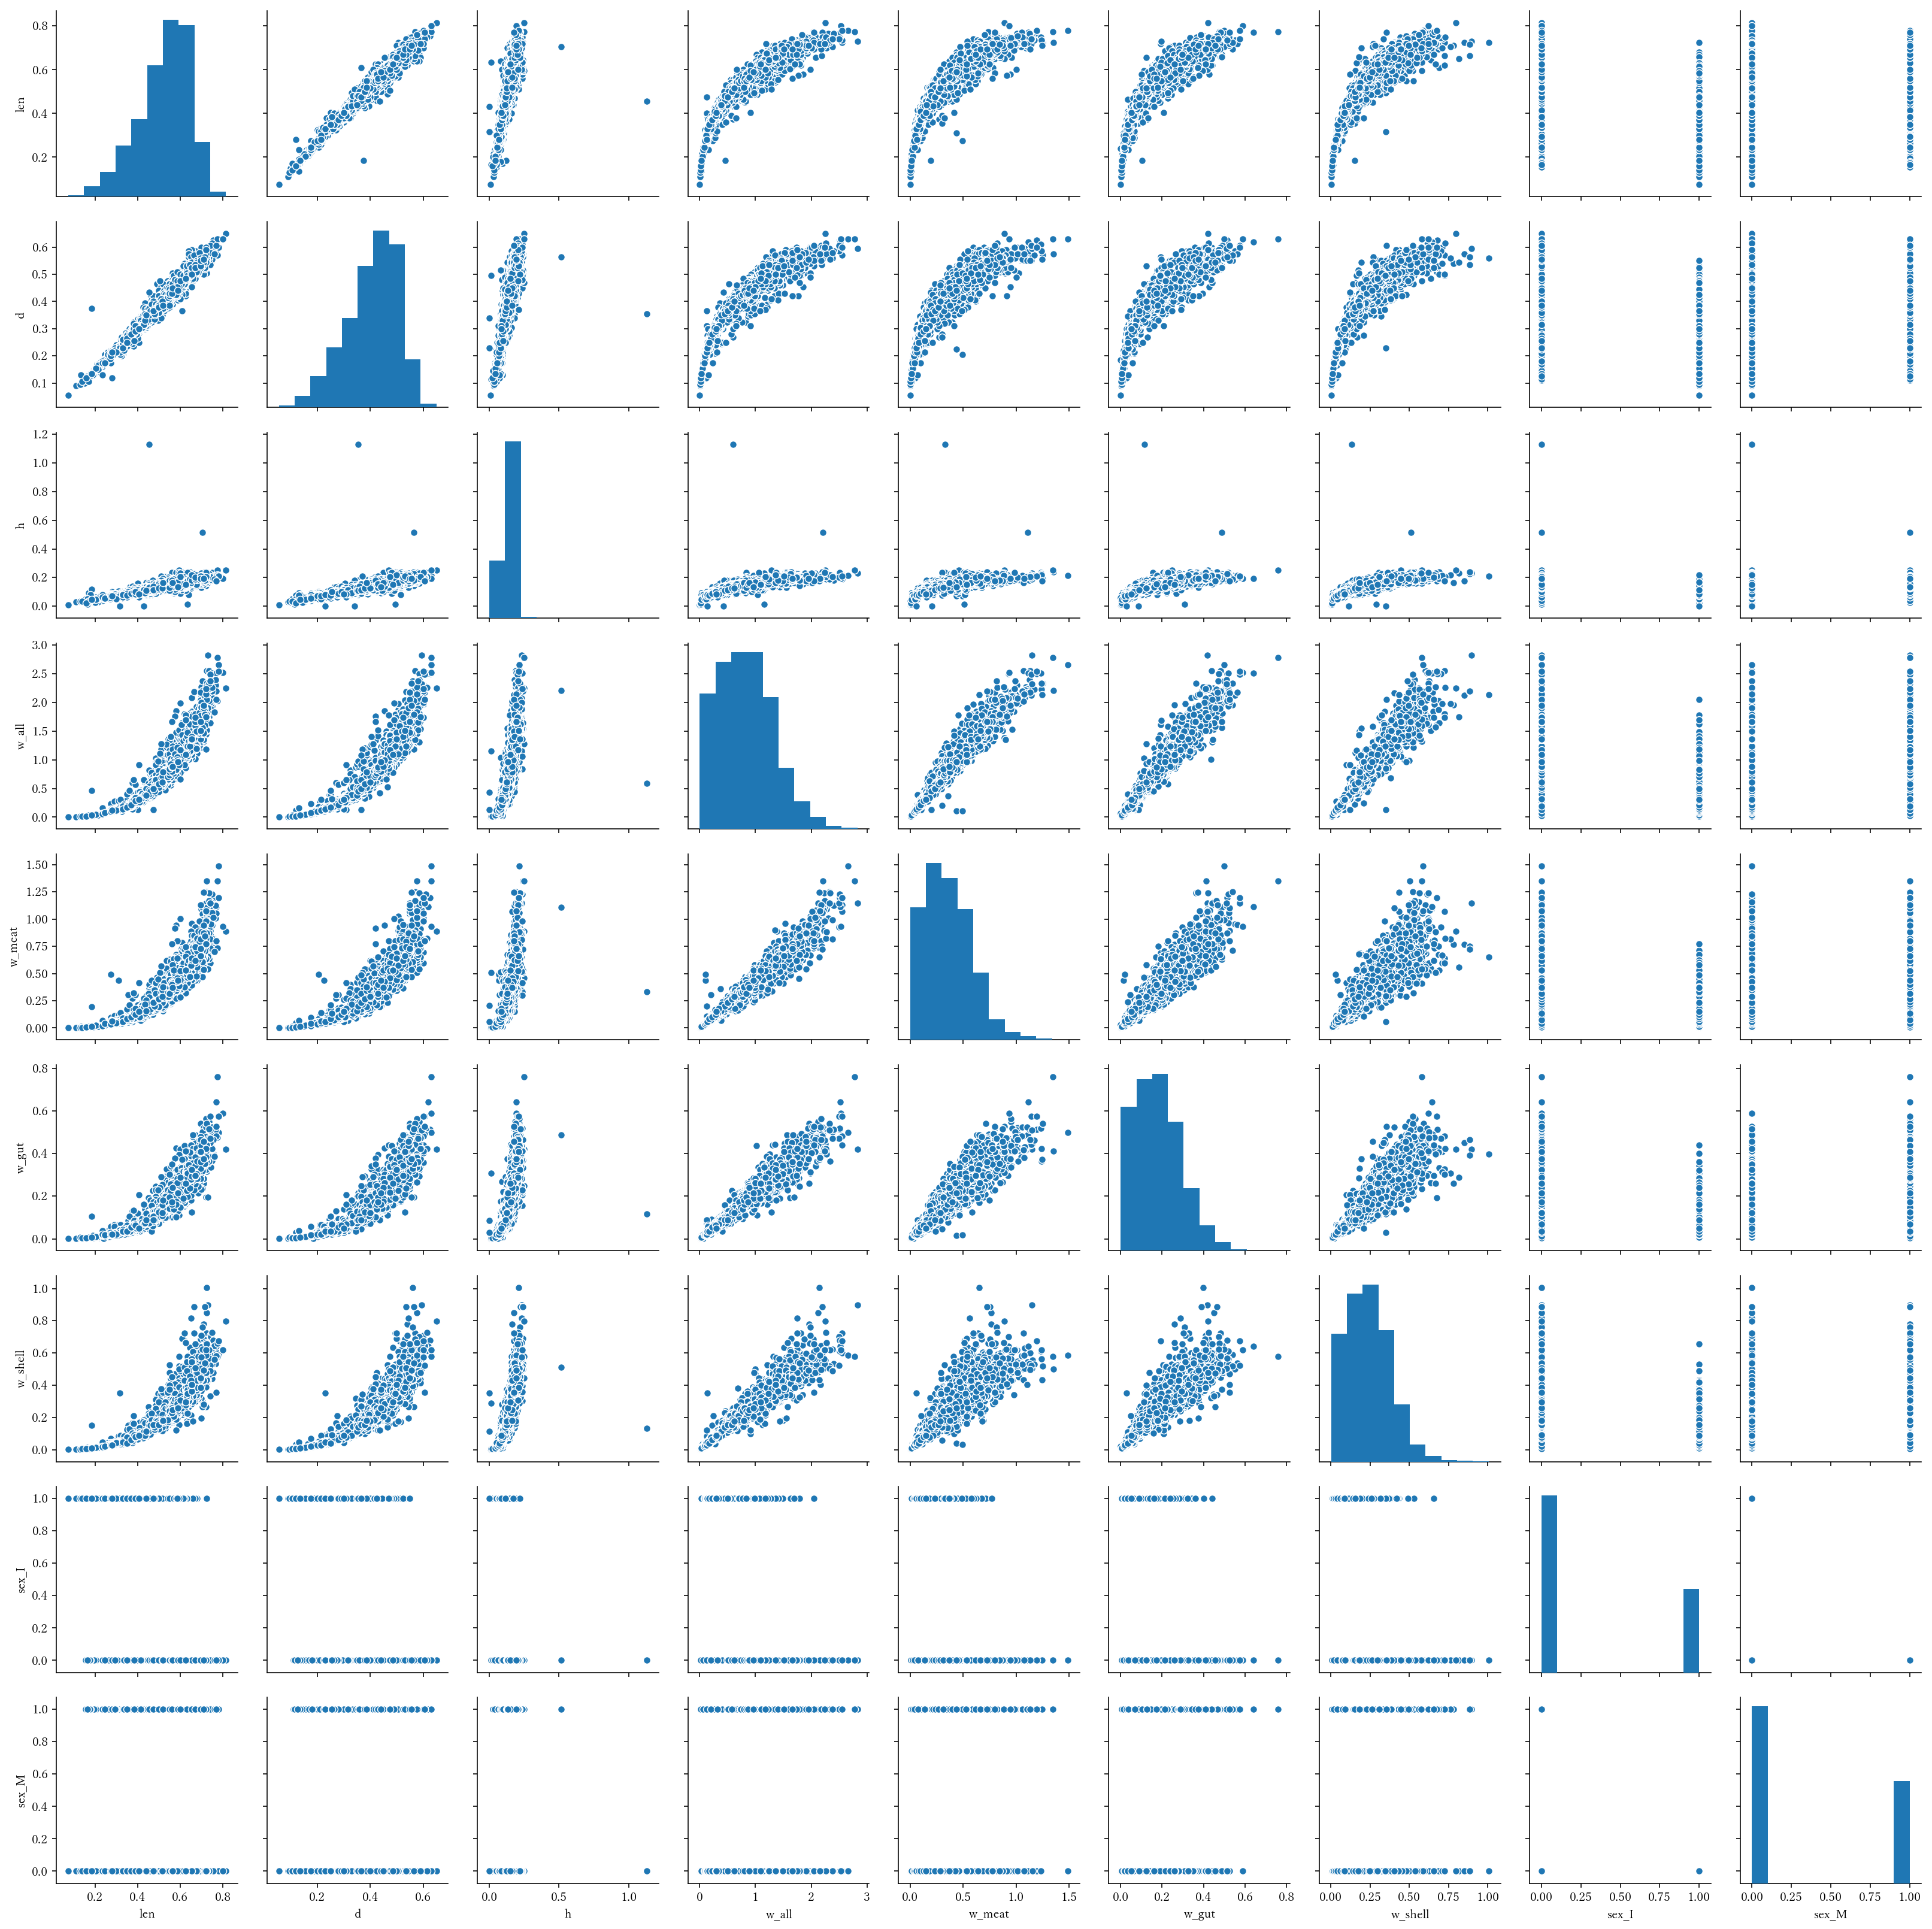

In [46]:
sns.pairplot(X_all)
plt.show()

##### Heatmap  
Heatmapを描いてもよい  

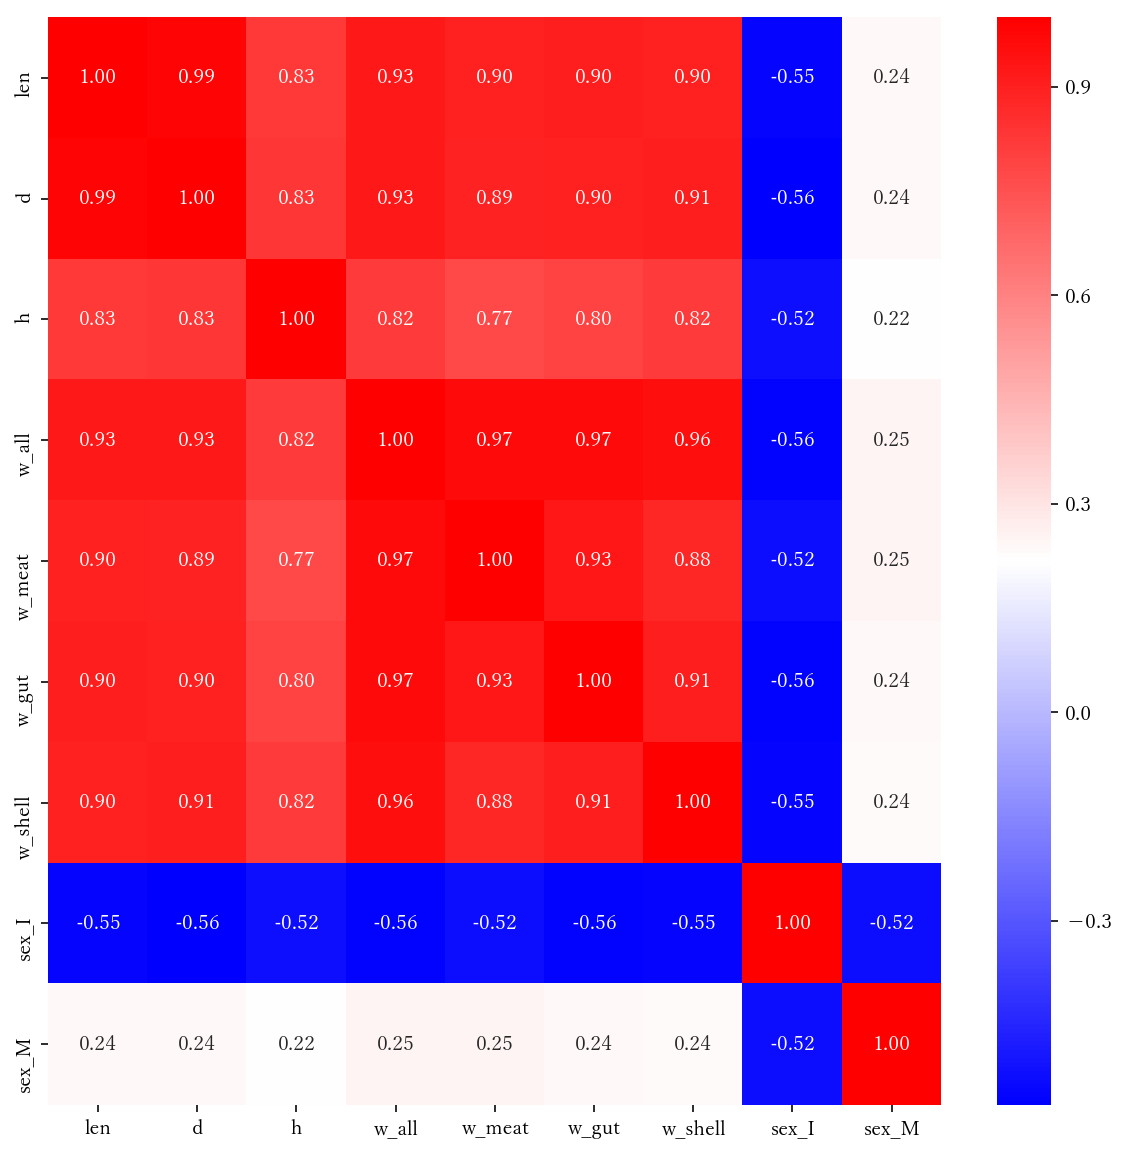

In [47]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_all,annot=True,fmt='.2f',cmap='bwr')
plt.show()

#### Step 3. MLR calculation using all variables  
全説明変数を用いて、標準化なしで線形重回帰分析  

In [48]:
X_all_c = sm.add_constant(X_all)
model = sm.OLS(y, X_all_c)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   ring   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     538.6
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:31:51   Log-Likelihood:                -9196.8
No. Observations:                4174   AIC:                         1.841e+04
Df Residuals:                    4164   BIC:                         1.848e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8927      0.292     13.352      0.0

In [49]:
#help(results)
#print(dir(results))  # To know all methods/attributes of an object

#### Step 4. Check R2 and Adjusted R2 to see whether MLR is appropriate for this data  
決定係数や自由度調整済み決定係数をみて、そもそも線形モデルの当てはめが妥当かどうかを判断  

In [50]:
print('R2:', results.rsquared)
print('Adj R2:', results.rsquared_adj)

R2: 0.5379311068528567
Adj R2: 0.5369323988705501


Rather good ...  

#### Step 5. Stat. test for MLR equation  
重回帰式の検定 (求めた重回帰式は目的変数を説明している？)  

In [51]:
print('p-values (F-statistic)', results.f_pvalue)

p-values (F-statistic) 0.0


Very small p-value, so this MLR equation is considered to be significant.  

#### Step 6. Standardization of variables  
Compare coefficients for explanatory variables  
全説明変数と目的変数を標準化して線形重回帰分析  
標準化偏回帰係数を比較　　

In [52]:
# NOTE: after scaling, X_scaled and Y_scaled are ndarray, not DataFrame.
X_scaled = preprocessing.scale(X_all)
y_scaled = preprocessing.scale(y)
model = sm.OLS(y_scaled, X_scaled)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     538.8
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:31:51   Log-Likelihood:                -4311.4
No. Observations:                4174   AIC:                             8641.
Df Residuals:                    4165   BIC:                             8698.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0179      0.067     -0.266      0.7

C:\Users\shugo\Miniconda3\envs\ds2019\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\Users\shugo\Miniconda3\envs\ds2019\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


#### Step 7.　Feature selection  
変数選択  

In [53]:
# NOTE: make DataFrames corresponding to X_scaled and y_scaled.
dfX_scaled = pd.DataFrame(X_scaled, columns=X_all.columns)
dfy_scaled = pd.Series(y_scaled, name=y.name)
exog = list(dfX_scaled.columns)  # Initial set = all explanatory variables
endog = [dfy_scaled.name]  # Objective variables
df_scaled = pd.concat([dfX_scaled, dfy_scaled], axis=1)

##### by forward selection method based on AIC  
変数増加法による変数選択  

In [54]:
results_aic=step_aic_forward(smf.ols, exog, endog, data=df_scaled)

AIC: 11847.299, formula: ring ~ 1
AIC: 10406.185, formula: ring ~ w_all
AIC: 9758.050, formula: ring ~ w_shell
AIC: 11708.375, formula: ring ~ sex_M
AIC: 10293.403, formula: ring ~ h
AIC: 11034.346, formula: ring ~ w_meat
AIC: 10625.364, formula: ring ~ w_gut
AIC: 10175.294, formula: ring ~ d
AIC: 10969.684, formula: ring ~ sex_I
AIC: 10299.876, formula: ring ~ len
AIC: 9475.064, formula: ring ~ w_shell + w_all
AIC: 9751.448, formula: ring ~ w_shell + sex_M
AIC: 9718.311, formula: ring ~ w_shell + h
AIC: 9169.481, formula: ring ~ w_shell + w_meat
AIC: 9587.967, formula: ring ~ w_shell + w_gut
AIC: 9758.451, formula: ring ~ w_shell + d
AIC: 9675.054, formula: ring ~ w_shell + sex_I
AIC: 9758.475, formula: ring ~ w_shell + len
AIC: 9021.620, formula: ring ~ w_shell + w_meat + w_all
AIC: 9140.034, formula: ring ~ w_shell + w_meat + sex_M
AIC: 9021.593, formula: ring ~ w_shell + w_meat + h
AIC: 9157.809, formula: ring ~ w_shell + w_meat + w_gut
AIC: 8940.150, formula: ring ~ w_shell + w_me

In [55]:
print(results_aic.aic)
print(results_aic.model.exog_names)
print(results_aic.model.endog_names)

8639.403306647066
['Intercept', 'w_shell', 'w_meat', 'd', 'sex_I', 'w_all', 'w_gut', 'h']
ring


#### Step 8. Check of multicolinearity (VIF checkup)  
マルチコのチェック  

- Iteration of Variable selection (selected_cols) <-> Check VIF  
until all VIFs < 10.  
- NOTE: standardization of variables does not affect the results   

Format of results of statsmodels:
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html  

In [56]:
endogs = results_aic.model.endog_names
exogs = results_aic.model.exog_names.copy()
exogs.remove('Intercept')
print(exogs)  # debug
X_c = sm.add_constant(X_all[exogs])
vifs = calc_vifs(X_c, y)
display(vifs)

['w_shell', 'w_meat', 'd', 'sex_I', 'w_all', 'w_gut', 'h']


C:\Users\shugo\Miniconda3\envs\ds2019\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,VIF
const,62.022437
w_shell,21.237845
w_meat,28.276245
d,8.337192
sex_I,1.512135
w_all,109.715404
w_gut,17.258319
h,3.575501


How to eliminate multicolinearity is case by case.  
Here we simply delete three explanatory variables with high VIF.  

In [57]:
exogs.remove('w_all')
exogs.remove('w_meat')
exogs.remove('w_shell')
print(exogs)  # debug
X_c = sm.add_constant(X_all[exogs])
vifs = calc_vifs(X_c, y)
display(vifs)

['d', 'sex_I', 'w_gut', 'h']


,VIF
const,50.267875
d,6.606041
sex_I,1.504112
w_gut,5.543189
h,3.437739


For all explantory variables, VIF < 10, so we can go forward.  

#### Step 9. Estimate the magnitude of the influence of each explanatory variable on the objective variable  
最終的に得られた標準化偏回帰係数から、各説明変数の目的変数に対する影響の大きさがわかる  

In [58]:
X_final_scaled = dfX_scaled[exogs]
model_final_scaled = sm.OLS(y_scaled, X_final_scaled)
results_final_scaled = model_final_scaled.fit()
print(results_final_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     614.2
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:31:51   Log-Likelihood:                -4955.9
No. Observations:                4174   AIC:                             9920.
Df Residuals:                    4170   BIC:                             9945.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d              0.4256      0.032     13.479      0.0

In [59]:
print(results_final_scaled.params)

d        0.425571
sex_I   -0.157683
w_gut   -0.174419
h        0.260505
dtype: float64


The order of strengths of influences on objective variables:  
    **d (positive) > h (positive) > w_gut (negative) > sex_I (negative)**  
（これが、目的変数ringに対する各説明変数(d, h, w_gut, sex_I)の影響の大きさ順）

#### Step 10. Stat. test for MLR equation  
重回帰式の検定 (求めた重回帰式は目的変数を説明している？)  

In [60]:
print('p-values (F-statistic)', results_final_scaled.f_pvalue)

p-values (F-statistic) 0.0


Very small p-value, so this MLR equation is considered to be significant.  

#### Step 11. MLR calculation using selected explanatory variables  
選択された説明変数を用いて、標準化なしで線形重回帰分析 

In [61]:
X_final_c = sm.add_constant(X_all[exogs])
model_final = sm.OLS(y, X_final_c)
results_final = model_final.fit()
print(results_final.summary())

                            OLS Regression Results                            
Dep. Variable:                   ring   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     614.1
Date:                Wed, 24 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:31:51   Log-Likelihood:                -9841.4
No. Observations:                4174   AIC:                         1.969e+04
Df Residuals:                    4169   BIC:                         1.972e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7696      0.281      9.864      0.0

#### Step 12. Check R2 and Adjusted R2  
決定係数や自由度調整済み決定係数をみて、線形モデルの当てはまりの良さをチェック  

In [62]:
print('R2:', results_final.rsquared)
print('Adj R2:', results_final.rsquared_adj)

R2: 0.3707362215803347
Adj R2: 0.37013246645592146


The fit of "the best model" is not good ...

#### Step 13. partial regression coefficients  
最終的に得られた偏回帰係数から、「各説明変数が1増えたときの目的変数の増分」がわかる。  

In [63]:
print(results_final.params)

const     2.769553
d        13.822066
sex_I    -1.088474
w_gut    -5.128734
h        20.074556
dtype: float64


Coefficients of MLR;  
Increment of objective variable when corresponding variable is increased by 1  
and other variables are not changed  

#### Obtained best model:
ring $\sim$ 2.770 + 20.075 * h + 13.822 * d + (-5.129) * w_gut + (-1.088) * sex_I  

#### Step 14. Do prediction using best model  
NOTICE: add 1 at the head of each data for constant.  
(You can use sm.add_constant() to add 1)
得られたベストモデルを用いて、予測を行う。  
注: 予測のための各Xデータの先頭には定数項用の1を付加すること。  
(sm.add_constant()を用いて付加してもよい)  

In [64]:
dfX_test = pd.DataFrame([[1, 0.1, 0, 0.1, 0.1],
                         [1, 0.2, 1, 0.2, 0.2],
                        ],
                        columns=results_final.params.index)  # example
print('X for prediction:')
display(dfX_test)
y_test = results_final.predict(dfX_test)
print('Predicted y:')
print(y_test)

X for prediction:


,const,d,sex_I,w_gut,h
0,1,0.1,0,0.1,0.1
1,1,0.2,1,0.2,0.2


Predicted y:
0    5.646342
1    7.434656
dtype: float64
